In [1]:
import numpy as np
import pandas as pd

In [2]:
pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 200)

### Utility Function

In [3]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

### Importing Preprocessed Data

In [4]:
df = pd.read_csv('../Data/Cleansed_Data.csv')
df = df.drop('Sum_delta', axis=1)
df.head()

,Events,Favourite,Underdog,Label,REACH_delta,SLPM_delta,SAPM_delta,STRA_delta,STRD_delta,TD_delta,TDA_delta,TDD_delta,SUBA_delta,Odds_delta
0,UFC 159 - Jones vs. Sonnen,Jon Jones,Chael Sonnen,Favourite,10,1.17,0.90,0.12,0.03,-1.56,-0.07,0.28,0.2,-7.87
1,UFC 159 - Jones vs. Sonnen,Leonard Garcia,Cody McKenzie,Underdog,-3,1.03,2.29,-0.10,-0.15,-2.20,0.01,0.28,-2.0,1.40
2,UFC Fight Night 34 - Saffiedine vs. Lim,Mairbek Taisumov,Tae Hyun Bang,Favourite,2,0.54,0.08,0.05,-0.05,1.75,0.44,0.28,-0.5,-2.89
3,UFC Fight Night 91 - McDonald vs. Lineker,Cody Pfister,Scott Holtzman,Underdog,4,-3.15,-0.85,-0.24,-0.06,0.55,-0.27,-0.58,-0.4,6.89
4,UFC Fight Night 91 - McDonald vs. Lineker,Matthew Lopez,Rani Yahya,Underdog,2,0.02,0.86,0.13,-0.06,-0.08,0.51,0.37,-0.5,0.81


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, classification_report, make_scorer, accuracy_score, recall_score, f1_score

#### Brief Insights

In [6]:
df.shape

(1315, 14)

In [7]:
df.dtypes

Events          object
Favourite       object
Underdog        object
Label           object
REACH_delta      int64
SLPM_delta     float64
SAPM_delta     float64
STRA_delta     float64
STRD_delta     float64
TD_delta       float64
TDA_delta      float64
TDD_delta      float64
SUBA_delta     float64
Odds_delta     float64
dtype: object

In [8]:
df.isna().sum()

Events         0
Favourite      0
Underdog       0
Label          0
REACH_delta    0
SLPM_delta     0
SAPM_delta     0
STRA_delta     0
STRD_delta     0
TD_delta       0
TDA_delta      0
TDD_delta      0
SUBA_delta     0
Odds_delta     0
dtype: int64

In [9]:
df['Label'].value_counts()/df.shape[0]

Favourite    0.627376
Underdog     0.372624
Name: Label, dtype: float64

#### We can see that in a total of 1315 entries there are 62.74% Favourites

<AxesSubplot:>

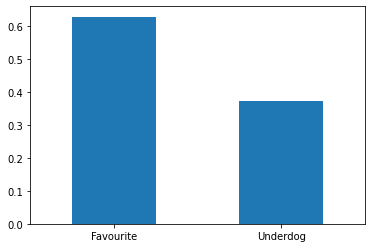

In [11]:
(df['Label'].value_counts()/df.shape[0]).plot(kind='bar', rot=0)

Encoding the target variable

In [12]:
df['Label'] = df['Label'].map(lambda x: 0 if x == 'Underdog' else 1)

# Feature Selection

* simplification of models to make them easier to interpret
* shorter training times (applicable to very huge datasets)
* to avoid the curse of dimensionality 
* enhanced generalization by reducing overfitting (reduction of variance)

From RFECV and Feature Importance as validation, we know:
* The 6 most important features are **'SLPM_delta', 'SAPM_delta', 'STRD_delta', 'TDD_delta', 'SUBA_delta', 'Odds_delta'**

In [13]:
def select_features(df):
    all_X = df.drop(['Events', 'Favourite', 'Underdog', 'Label'], axis=1)
    all_y = df['Label']
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf)
    selector.fit(all_X, all_y)
    best_columns = list(all_X.columns[selector.support_])
    print('Best Columns \n' + '-'*12 + '\n' + '{}'.format(best_columns))
    
    return best_columns

## Recursive Feature Elimination with Cross Validation (RFECV)

The features will be selected based on Recursive Feature Elimination with Cross Validation [**(RFECV)**](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html). Recursive Feature Elimination (RFE) works by training the model, evaluating it, then removing the least significant features, and repeating.

In [14]:
best_cols = select_features(df)

Best Columns 
------------
['SLPM_delta', 'SAPM_delta', 'STRD_delta', 'TDD_delta', 'SUBA_delta', 'Odds_delta']


## Feature Importance

* Not suprising **Reach_delta** is of least importance since reach does not really determine a clear winner

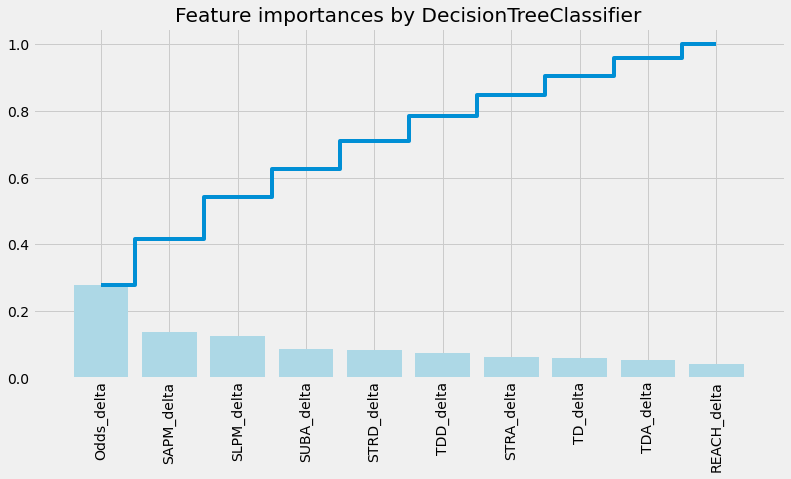

In [15]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)

# Create train and test splits
target_name = 'Label'
X = df.drop(['Events', 'Favourite', 'Underdog', 'Label'], axis=1)


y=df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=1, stratify=y)

dtree = RandomForestClassifier(
    #max_depth=3,
    random_state = 1,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree = dtree.fit(X_train,y_train)

## plot the importances ##
importances = dtree.feature_importances_
feat_names = df.drop(['Events', 'Favourite', 'Underdog', 'Label'], axis=1).columns


indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

In [51]:
from imblearn.over_sampling import SMOTE

# Building and saving final Model

* The final model selected, Neural Network (MLP) to predict winners from Favourite and Underdog has an **accuracy of ~80.01%**


In [48]:
y = df['Label']
X = df[best_cols]

In [53]:
sm = SMOTE(random_state=27)
X, y = sm.fit_resample(X, y)

mlp = MLPClassifier(random_state=27, activation='relu', learning_rate='constant', solver='adam')

mlp.fit(X, y)

c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=27)

In [54]:
import pickle